In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import geopandas as gpd

### processing the two dataframes

In [93]:
new = pd.read_csv("../data/ag2016_2022_icrisat_harmonized.csv").iloc[:, 1:]
new = new.rename(columns={'ag_hy_crop': 'crop'}).drop(columns='Dist_Name')
new.loc[new['n_hybrid']==1, "match"] = "identical"
new.loc[new['n_hybrid']>1, "match"] = "mixed"
new['year'] = pd.to_numeric(new['year'])

zero_condition = (new['area_harvested'] == 0) & (new['production'] == 0) & (new['yield'] == 0)
new.loc[zero_condition, ['area_harvested', 'production', 'yield']] = np.nan

In [94]:
df = pd.read_csv("/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/icrisat_apportioned/ICRISAT-District Level Data_Apportioned.csv")
df.loc[(df['State Name']=="Uttar Pradesh") & (df['Dist Name']== "Saharanpur"), "State Name"] = "Uttaranchal"
df = df.rename(columns={'Dist Name': 'Name_12', 'State Name': 'NAME_1'}).drop(columns={'Dist Code', 'State Code'})

df= pd.melt(df, id_vars=["Year", "NAME_1", "Name_12"], var_name= "var", value_name = "value" )
df[['crop', 'variable']] = df['var'].str.extract(r'^(.*?)\s(AREA|PRODUCTION|YIELD)', expand=True)
df = df.drop(columns='var')
df['crop'] = df['crop'].str.capitalize()
df['variable'] = df['variable'].str.lower()
df = df.pivot(index=["Year", "NAME_1", "Name_12", "crop"], columns= "variable", values="value" ).reset_index().rename_axis(None,axis=1)
df = df.rename(columns={"Year": 'year', 'area': "area_harvested"})
df['match'] = "original"
df['year'] = pd.to_numeric(df['year'])
df['yield']= df['yield']/1000

zero_condition = (df['area_harvested'] == 0) & (df['production'] == 0) & (df['yield'] == 0)
df.loc[zero_condition, ['area_harvested', 'production', 'yield']] = np.nan

In [95]:
sorted(df['crop'].unique())

['Barley',
 'Castor',
 'Chickpea',
 'Cotton',
 'Finger millet',
 'Fodder',
 'Fruits',
 'Fruits and vegetables',
 'Groundnut',
 'Kharif sorghum',
 'Linseed',
 'Maize',
 'Minor pulses',
 'Oilseeds',
 'Onion',
 'Pearl millet',
 'Pigeonpea',
 'Potatoes',
 'Rabi sorghum',
 'Rapeseed and mustard',
 'Rice',
 'Safflower',
 'Sesamum',
 'Sorghum',
 'Soyabean',
 'Sugarcane',
 'Sunflower',
 'Vegetables',
 'Wheat']

In [96]:
# compare = oldcrops.merge(newcrops, indicator=True, how='outer')
# newcrops= new[['crop']].drop_duplicates().sort_values(by='crop')
# newcrops.to_csv("../data/cropkey_edit_in_excel.csv")
key = pd.read_csv("../data/cropkey.csv").dropna(subset='crop')
crop_mapping = dict(zip(key['crop'], key['icrisat_crop']))
new['crop'] = new['crop'].replace(crop_mapping)

### comparing 2016 and 2017

In [97]:
y16_harv = new[new['year']==2016]
y17_harv = new[new['year']==2017]
y16_icri = df[df['year']==2016]
y17_icri = df[df['year']==2017]

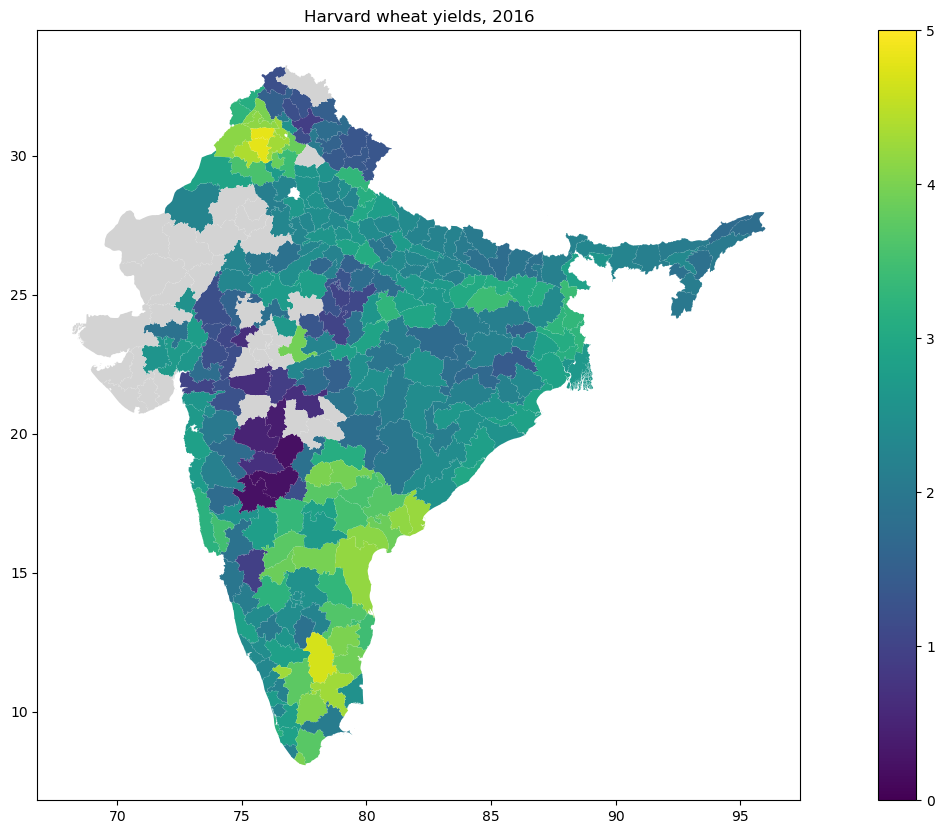

In [98]:
shp_path = "/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/icrisat_apportioned/icrisat_boundary_match.shp"
icri = gpd.read_file(shp_path)[['NAME_1', "Name_12", "geometry"]]

test_harv = y16_harv[y16_harv['crop']=="Rice"]
test_harv = gpd.GeoDataFrame(icri.merge(test, how="left"))

fig, ax = plt.subplots(figsize=(20, 10))
test_harv.plot(ax=ax, column="yield", vmin=0, vmax=5, legend=True, 
         missing_kwds=dict(color="lightgray"))
plt.title("Harvard wheat yields, 2016")
plt.savefig("./plots/rice16_harv.png")
plt.show()

In [99]:

test['production'].sum()

np.float64(117441.45000000001)

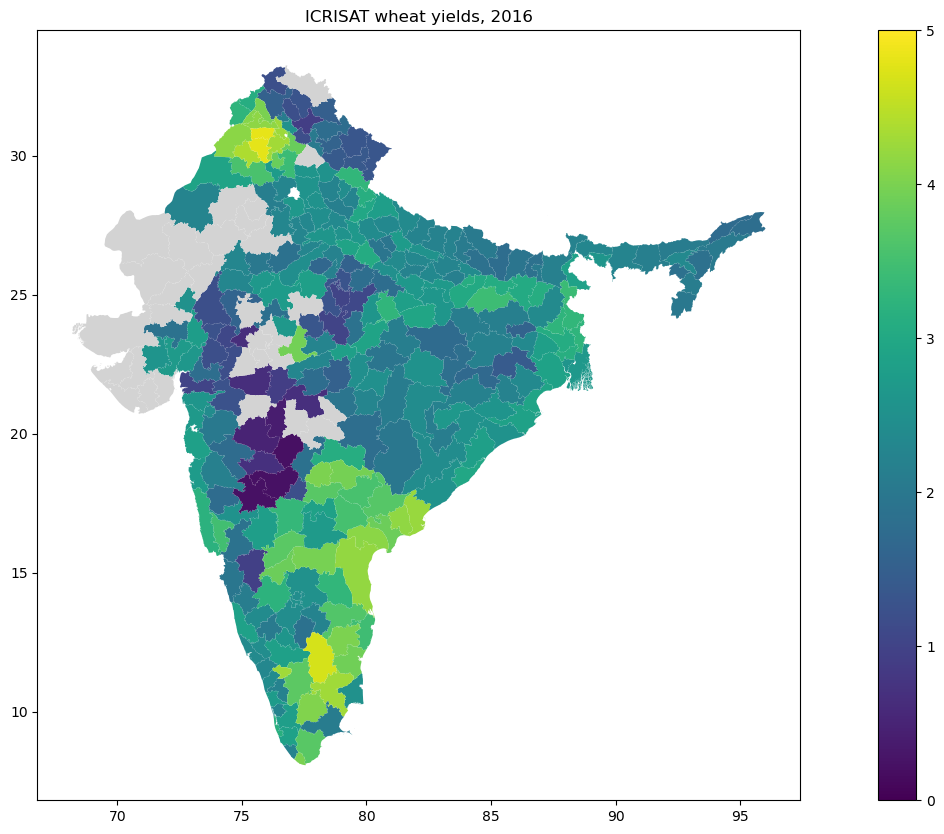

In [100]:
test = y16_icri[y16_icri['crop']=="Rice"]
test = gpd.GeoDataFrame(icri.merge(test, how="left"))

fig, ax = plt.subplots(figsize=(20, 10))
test.plot(ax=ax, column="yield", vmin=0, vmax=5, legend=True, 
         missing_kwds=dict(color="lightgray"))
plt.title("ICRISAT wheat yields, 2016")
plt.savefig("./plots/rice16_icri.png")
plt.show()

In [101]:
comp16= pd.merge(y16_harv, y16_icri, on=['NAME_1', 'Name_12', 'year', 'crop'], suffixes=('_harv', '_icri'))
comp17= pd.merge(y17_harv, y17_icri, on=['NAME_1', 'Name_12', 'year', 'crop'], suffixes=('_harv', '_icri'))

In [102]:
comp16['area_harvested_diff'] = (comp16['area_harvested_harv'] - comp16['area_harvested_icri']) / ((comp16['area_harvested_harv'] + comp16['area_harvested_icri'])/2) * 100
comp16['production_diff'] = (comp16['production_harv'] - comp16['production_icri']) / ((comp16['production_harv'] + comp16['production_icri'])/2) * 100
comp16['yield_diff'] = (comp16['yield_harv'] - comp16['yield_icri']) / ((comp16['yield_harv'] + comp16['yield_icri'])/2) *100

In [103]:
comp17['area_harvested_diff'] = (comp17['area_harvested_harv'] - comp17['area_harvested_icri']) / ((comp17['area_harvested_harv'] + comp17['area_harvested_icri'])/2) * 100
comp17['production_diff'] = (comp17['production_harv'] - comp17['production_icri']) / ((comp17['production_harv'] + comp17['production_icri'])/2) * 100
comp17['yield_diff'] = (comp17['yield_harv'] - comp17['yield_icri']) / ((comp17['yield_harv'] + comp17['yield_icri'])/2)* 100

<Figure size 1000x600 with 0 Axes>

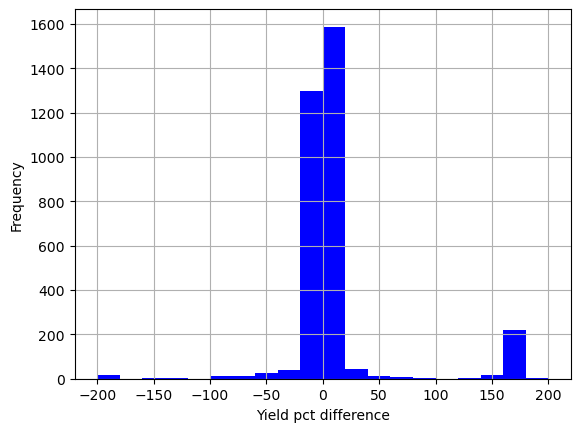

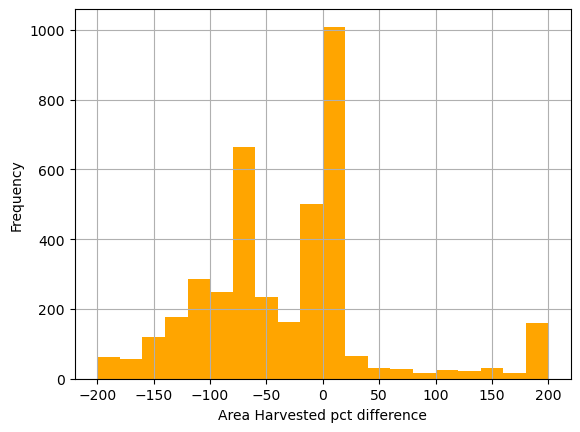

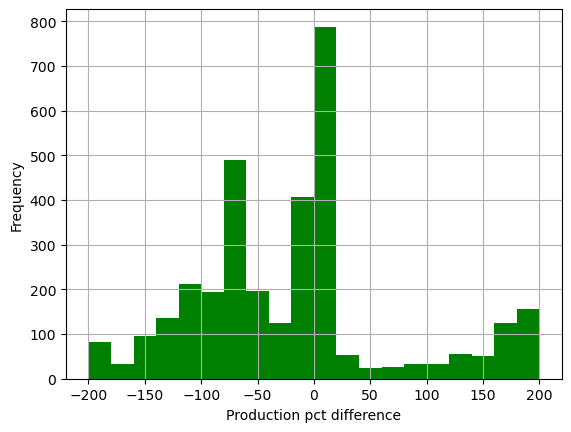

In [104]:
plt.figure(figsize=(10, 6))

plt.figure()
comp16['yield_diff'].hist(bins=20, color="blue")
plt.xlabel("Yield pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 2: Area Harvested
plt.figure()
comp16['area_harvested_diff'].hist(bins=20, color="orange")
plt.xlabel("Area Harvested pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 3: Production
plt.figure()
comp16['production_diff'].hist(bins=20, color='green')
plt.xlabel("Production pct difference")
plt.ylabel("Frequency")
plt.show()


<Figure size 1000x600 with 0 Axes>

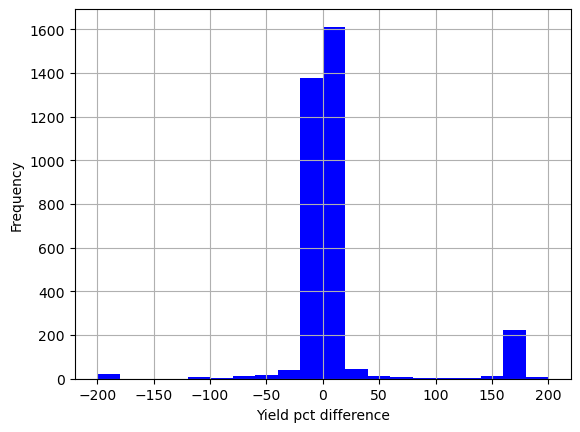

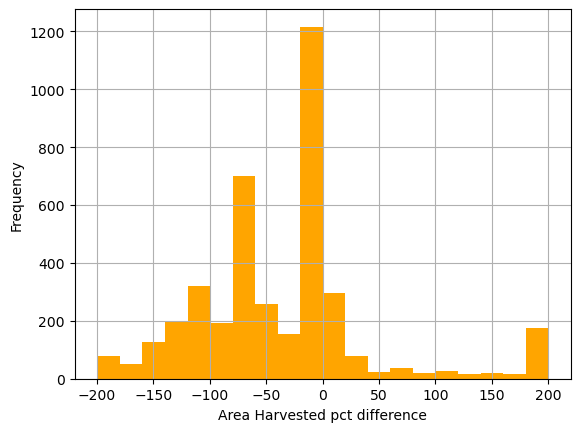

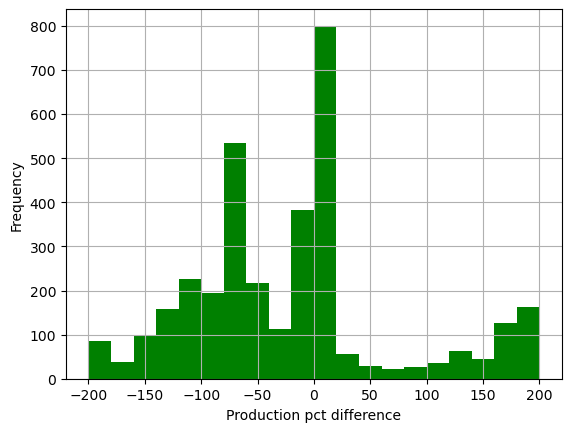

In [105]:
plt.figure(figsize=(10, 6))

plt.figure()
comp17['yield_diff'].hist(bins=20, color="blue")
plt.xlabel("Yield pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 2: Area Harvested
plt.figure()
comp17['area_harvested_diff'].hist(bins=20, color="orange")
plt.xlabel("Area Harvested pct difference")
plt.ylabel("Frequency")
plt.show()

# Histogram 3: Production
plt.figure()
comp17['production_diff'].hist(bins=20, color='green')
plt.xlabel("Production pct difference")
plt.ylabel("Frequency")
plt.show()


In [106]:
comp16.loc[abs(comp16['yield_diff'])<1, "yield_alignment"] = "<1% diff"
comp16.loc[(abs(comp16['yield_diff']) > 1) & (abs(comp16['yield_diff']) <= 10), "yield_alignment"] = "1-10% diff"
comp16.loc[abs(comp16['yield_diff'])>10, "yield_alignment"] = ">10% diff"

In [107]:
comp17.loc[abs(comp17['yield_diff'])<1, "yield_alignment"] = "<1% diff"
comp17.loc[(abs(comp17['yield_diff']) > 1) & (abs(comp17['yield_diff']) <= 10), "yield_alignment"] = "1-10% diff"
comp17.loc[abs(comp17['yield_diff'])>10, "yield_alignment"] = ">10% diff"

In [108]:
merge16 = comp16[['NAME_1', 'Name_12', 'year', 'crop', 'yield_alignment']]
merge17 = comp17[['NAME_1', 'Name_12', 'year', 'crop', 'yield_alignment']]
tomerge = pd.concat([merge16, merge17])

### merging the two

In [109]:
full_ts = pd.concat([df, new])
full_ts

,year,NAME_1,Name_12,crop,area_harvested,production,yield,match,n_hybrid,seasons,duplicated
0,1966,Andhra Pradesh,Ananthapur,Barley,NaN,NaN,NaN,original,NaN,NaN,NaN
1,1966,Andhra Pradesh,Ananthapur,Castor,10.900000,2.100000,0.192660,original,NaN,NaN,NaN
2,1966,Andhra Pradesh,Ananthapur,Chickpea,2.000000,1.000000,0.500000,original,NaN,NaN,NaN
3,1966,Andhra Pradesh,Ananthapur,Cotton,42.000000,2.000000,0.047620,original,NaN,NaN,NaN
4,1966,Andhra Pradesh,Ananthapur,Finger millet,39.000000,29.000000,0.743590,original,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
50630,2022,West Bengal,West Dinajpur,Rice,77.979306,232.711278,2.984270,mixed,2.0,3.000000,False
50631,2022,West Bengal,West Dinajpur,Sesamum,0.430792,0.298417,0.692717,mixed,2.0,1.416667,False
50632,2022,West Bengal,West Dinajpur,Sugarcane,0.367417,30.495583,83.000000,mixed,2.0,1.000000,False
50633,2022,West Bengal,West Dinajpur,Urad,1.134333,0.811708,0.715582,mixed,2.0,1.583333,False


In [112]:
full_ts['crop'].unique()

array(['Barley', 'Castor', 'Chickpea', 'Cotton', 'Finger millet',
       'Fodder', 'Fruits', 'Fruits and vegetables', 'Groundnut',
       'Kharif sorghum', 'Linseed', 'Maize', 'Minor pulses', 'Oilseeds',
       'Onion', 'Pearl millet', 'Pigeonpea', 'Potatoes', 'Rabi sorghum',
       'Rapeseed and mustard', 'Rice', 'Safflower', 'Sesamum', 'Sorghum',
       'Soyabean', 'Sugarcane', 'Sunflower', 'Vegetables', 'Wheat',
       'Arecanut', 'Banana', 'Cashewnut', 'Coconut', 'Coriander',
       'Cowpea(Lobia)', 'Dry chillies', 'Horse-gram', 'Moong(Green Gram)',
       'Small millets', 'Tobacco', 'Urad', 'Sweet potato', 'Turmeric',
       'Black pepper', 'Ginger', 'Guar seed', 'Tapioca', 'Sannhamp',
       'Niger seed', 'Mesta', 'Jute', 'Masoor', 'Peas & beans (Pulses)',
       'Garlic', 'Khesari', 'Jowar', 'Moth', 'Other Cereals', 'Cardamom'],
      dtype=object)

In [113]:
full_ts = full_ts[full_ts['crop'] != "Jowar"]

In [114]:
full_ts['match'] = full_ts['match'].astype(str).str.strip() 

notavg = full_ts.groupby(['year', 'NAME_1', 'Name_12', 'crop', 'match'], as_index=False).agg({
    'area_harvested': 'mean',
    'production': 'mean',
    'yield': 'mean',
    'n_hybrid': 'mean'})

notavg.to_csv("../data/icrisat_1966_2022_1617NOTAVG.csv", index=False)

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_49534/3056558065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_ts['match'] = full_ts['match'].astype(str).str.strip()


In [115]:
def unique_match(strings):
    strings = strings.dropna().astype(str)
    unique_values = sorted(strings.unique()) 
    return ', '.join(unique_values) if len(unique_values) > 1 else unique_values[0] if len(unique_values) == 1 else None

final = full_ts.groupby(['year', 'NAME_1', 'Name_12', 'crop'], as_index=False).agg({
    'area_harvested': 'mean',
    'production': 'mean',
    'yield': 'mean',
    'n_hybrid': 'mean',
    'seasons' : 'mean',
    'duplicated': unique_match,
    'match': unique_match  })

In [116]:
###new[(new['NAME_1']=="Uttar Pradesh") & (new['Name_12']=="Pilibhit") & (new['crop']=="Dry chillies")]

In [117]:
np.unique(final['match'])

array(['identical', 'identical, original', 'mixed', 'mixed, original',
       'original'], dtype=object)

In [118]:
final = final.rename(columns={'yield': 'yield_fake'})
final['yield'] = final['production']/final['area_harvested']

In [119]:
check= final['yield']- final['yield_fake']
check.describe()

/Users/michaelfoley/miniforge3/envs/pygeo/lib/python3.13/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    2.840210e+05
mean              NaN
std               NaN
min              -inf
25%     -1.818182e-06
50%      0.000000e+00
75%      1.686747e-06
max               inf
dtype: float64

In [120]:
final['crop'].unique()

array(['Barley', 'Castor', 'Chickpea', 'Cotton', 'Finger millet',
       'Fodder', 'Fruits', 'Fruits and vegetables', 'Groundnut',
       'Kharif sorghum', 'Linseed', 'Maize', 'Minor pulses', 'Oilseeds',
       'Onion', 'Pearl millet', 'Pigeonpea', 'Potatoes', 'Rabi sorghum',
       'Rapeseed and mustard', 'Rice', 'Safflower', 'Sesamum', 'Sorghum',
       'Soyabean', 'Sugarcane', 'Sunflower', 'Vegetables', 'Wheat',
       'Arecanut', 'Banana', 'Cashewnut', 'Coconut', 'Coriander',
       'Cowpea(Lobia)', 'Dry chillies', 'Horse-gram', 'Moong(Green Gram)',
       'Small millets', 'Tobacco', 'Urad', 'Ginger', 'Guar seed',
       'Sweet potato', 'Tapioca', 'Turmeric', 'Niger seed', 'Mesta',
       'Black pepper', 'Jute', 'Masoor', 'Peas & beans (Pulses)',
       'Garlic', 'Khesari', 'Sannhamp', 'Moth', 'Other Cereals',
       'Cardamom'], dtype=object)

In [121]:
fin = final.drop(columns="yield_fake").merge(tomerge, how="left")
fin

,year,NAME_1,Name_12,crop,area_harvested,production,n_hybrid,seasons,duplicated,match,yield,yield_alignment
0,1966,Andhra Pradesh,Ananthapur,Barley,NaN,NaN,NaN,NaN,None,original,NaN,NaN
1,1966,Andhra Pradesh,Ananthapur,Castor,10.900000,2.100000,NaN,NaN,None,original,0.192661,NaN
2,1966,Andhra Pradesh,Ananthapur,Chickpea,2.000000,1.000000,NaN,NaN,None,original,0.500000,NaN
3,1966,Andhra Pradesh,Ananthapur,Cotton,42.000000,2.000000,NaN,NaN,None,original,0.047619,NaN
4,1966,Andhra Pradesh,Ananthapur,Finger millet,39.000000,29.000000,NaN,NaN,None,original,0.743590,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
510664,2022,West Bengal,West Dinajpur,Rice,77.979306,232.711278,2.0,3.000000,False,mixed,2.984270,NaN
510665,2022,West Bengal,West Dinajpur,Sesamum,0.430792,0.298417,2.0,1.416667,False,mixed,0.692717,NaN
510666,2022,West Bengal,West Dinajpur,Sugarcane,0.367417,30.495583,2.0,1.000000,False,mixed,83.000000,NaN
510667,2022,West Bengal,West Dinajpur,Urad,1.134333,0.811708,2.0,1.583333,False,mixed,0.715582,NaN


In [122]:
os.system('say "done"')

0

In [123]:
fin.to_csv("../data/icrisat_1966_2022.csv", index=False)